<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_Preprocessing_Tranining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.optimizers import Adam

In [2]:
data_dir = '/content/drive/MyDrive/Research/Crowd Emotion/Spectrograms/Mel/'
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3857


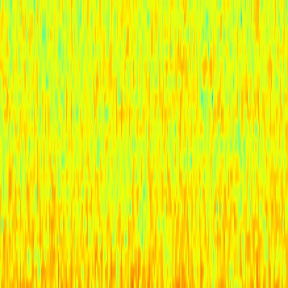

In [4]:
approvals = list(data_dir.glob('Approval/*'))
PIL.Image.open(str(approvals[300]))

In [5]:
batch_size = 32
img_height = 227
img_width = 227

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "training",
    seed                      = 42,
    image_size                = (img_height, img_width),
    batch_size                = batch_size
)

Found 3857 files belonging to 3 classes.
Using 3086 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "validation",
    seed                      = 42,
    image_size                = (img_height, img_width),
    batch_size                = batch_size
)

Found 3857 files belonging to 3 classes.
Using 771 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Approval', 'Disapproval', 'Neutral']


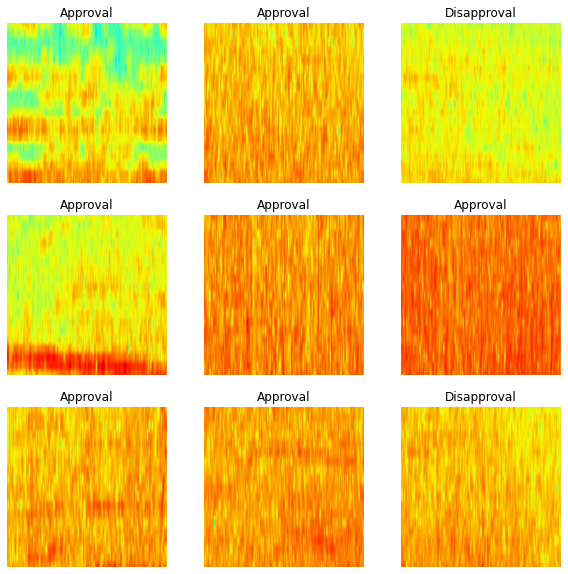

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 3

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(
    optimizer     = Adam(learning_rate=0.001),
    loss          = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics       = ['accuracy']
  )

In [15]:
history = model.fit(
  train_ds,
  validation_data   = val_ds,
  epochs            = 20
)

Epoch 1/20
97/97 [==============================] - 1570s 16s/step - loss: 0.9799 - accuracy: 0.5547 - val_loss: 0.8718 - val_accuracy: 0.5590
Epoch 2/20
97/97 [==============================] - 3s 35ms/step - loss: 0.8000 - accuracy: 0.6091 - val_loss: 0.8018 - val_accuracy: 0.6524
Epoch 3/20
97/97 [==============================] - 3s 34ms/step - loss: 0.7504 - accuracy: 0.6834 - val_loss: 0.7855 - val_accuracy: 0.6537
Epoch 4/20
97/97 [==============================] - 3s 34ms/step - loss: 0.6764 - accuracy: 0.7122 - val_loss: 0.8054 - val_accuracy: 0.6719
Epoch 5/20
97/97 [==============================] - 3s 34ms/step - loss: 0.6268 - accuracy: 0.7414 - val_loss: 0.7713 - val_accuracy: 0.6874
Epoch 6/20
97/97 [==============================] - 3s 34ms/step - loss: 0.5517 - accuracy: 0.7856 - val_loss: 0.8461 - val_accuracy: 0.6887
Epoch 7/20
97/97 [==============================] - 3s 35ms/step - loss: 0.4864 - accuracy: 0.8221 - val_loss: 1.0376 - val_accuracy: 0.6680
Epoch 8/20


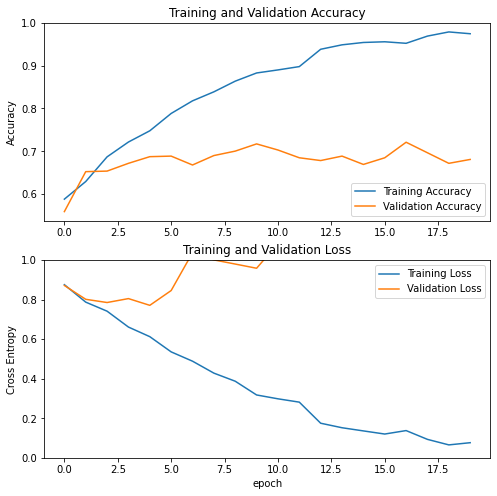

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
"""
                TRAINING           TESTING
        BARK      99.92             95.85
        ERB       96.96             72.11
        LOG      100.00             96.37
        MEL       97.25             68.09
"""

'\n                TRAINING        VALIDATION\n        BARK      99.92             95.85\n        ERB       96.96             72.11\n        LOG      100.00             96.37\n        MEL       \n'